# PROBLEM STATEMENT
# Deliverables
- Long average handle time (AHT) affects both efficiency and customer satisfaction. Explore the **factors contributing to extended call durations, such as agent performance, call types, and sentiment**. Identify key **drivers of long AHT and AST, especially during high volume call periods**. Additionally, could you **quantify the percentage difference between the average handling time for the most frequent and least frequent call reasons**

- We often observe self-solvable issues unnecessarily escalating to agents, increasing their workload. **Analyse the transcripts and call reasons to identify granular reasons associated to recurring problems that could be resolved via self-service options** in the IVR system. Propose specific improvements to the IVR options to effectively reduce agent intervention in these cases, along with solid reasoning to support your recommendations.

- Understanding the **primary reasons for incoming calls** is vital for enhancing operational efficiency and improving customer service. Accurately categorizing call reasons enables the call center to streamline processes, reduce manual tagging efforts, and ensure that customers are directed to the appropriate resources. In this context, **analyze the dataset to uncover patterns that can assist in understanding and identifying these primary call reasons**.
- Outline your approach, detailing the data analysis techniques and feature identification methods you plan to use. 
- Optional task, you may utilize the `test.csv` file to generate and submit your predictions

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Calling datasets
calls = pd.read_csv("calls.csv")
customers = pd.read_csv("customers.csv")
sent_stat = pd.read_csv("sentiment_statistics.csv")
reason = pd.read_csv("reason.csv")

# 0. DATA PREPROCESSING
- JOINING DIFFERENT DATASETS
- HANDLING MISSING VALUES
- CONVERSION OF SOME COLUMNS INTO DATETIME DATATYPES
- CREATING OUR METRICS - AHT & AST

In [3]:
result_inner = pd.merge(calls, reason, on='call_id', how='inner')

In [4]:
result = pd.merge(result_inner, sent_stat, on = 'call_id', how = 'inner')

In [5]:
result = result.drop('agent_id_y', axis=1)

In [6]:
result.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)

In [7]:
result.head()

call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   
2  6834291559   2416856629    158319     7/31/2024 23:59   
3  2266439882   1154544516    488324       8/1/2024 0:05   
4  1211603231   5214456437    721730       8/1/2024 0:04   

  agent_assigned_datetime call_end_datetime  \
0           8/1/2024 0:03     8/1/2024 0:34   
1           8/1/2024 0:06     8/1/2024 0:18   
2           8/1/2024 0:07     8/1/2024 0:26   
3           8/1/2024 0:10     8/1/2024 0:17   
4           8/1/2024 0:14     8/1/2024 0:23   

                                     call_transcript primary_call_reason  \
0  \n\nAgent: Thank you for calling United Airlin...   Voluntary  Cancel   
1  \n\nAgent: Thank you for calling United Airlin...             Booking   
2  \n\nAgent: Thank you for calling United Airlin...              IRROPS   
3  \n\nAgent: Thank you for calling United Airlin...             Upgrade   
4  \n\nAgent: Thank you for calling United Airlin...             Seating   

  agent_tone customer_tone  average_sentiment  silence_percent_average  
0    neutral         angry              -0.04                     0.39  
1       calm       neutral               0.02                     0.35  
2    neutral        polite              -0.13                     0.32  
3    neutral    frustrated              -0.20                     0.20  
4    neutral        polite              -0.05                     0.35

In [8]:
final_result = pd.merge(result, customers, on = 'customer_id', how = 'inner')
final_result.shape

(66653, 14)

In [9]:
final_result.head(3)

call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   
2  6834291559   2416856629    158319     7/31/2024 23:59   

  agent_assigned_datetime call_end_datetime  \
0           8/1/2024 0:03     8/1/2024 0:34   
1           8/1/2024 0:06     8/1/2024 0:18   
2           8/1/2024 0:07     8/1/2024 0:26   

                                     call_transcript primary_call_reason  \
0  \n\nAgent: Thank you for calling United Airlin...   Voluntary  Cancel   
1  \n\nAgent: Thank you for calling United Airlin...             Booking   
2  \n\nAgent: Thank you for calling United Airlin...              IRROPS   

  agent_tone customer_tone  average_sentiment  silence_percent_average  \
0    neutral         angry              -0.04                     0.39   
1       calm       neutral               0.02                     0.35   
2    neutral        polite              -0.13                     0.32   

    customer_name  elite_level_code  
0  Matthew Foster               4.0  
1   Tammy Walters               NaN  
2   Jeffery Dixon               NaN

In [10]:
# Fill the Null values of elite level code with 0
final_result['elite_level_code'].fillna(0, inplace = True)

# 1. CHECKING FOR MISSING VALUES

In [11]:
final_result.isnull().any()

call_id                    False
customer_id                False
agent_id                   False
call_start_datetime        False
agent_assigned_datetime    False
call_end_datetime          False
call_transcript            False
primary_call_reason        False
agent_tone                  True
customer_tone              False
average_sentiment           True
silence_percent_average    False
customer_name              False
elite_level_code           False
dtype: bool

In [12]:
final_result.isnull().sum()

call_id                      0
customer_id                  0
agent_id                     0
call_start_datetime          0
agent_assigned_datetime      0
call_end_datetime            0
call_transcript              0
primary_call_reason          0
agent_tone                 198
customer_tone                0
average_sentiment          101
silence_percent_average      0
customer_name                0
elite_level_code             0
dtype: int64

In [13]:
# Dropping rows with Null values
final_result.dropna(inplace = True)
final_result.shape

(66455, 14)

# 2. CREATING OUR METRIC 
### HANDLE TIME & SPEED TO ANSWER(STA) TIME
### CONVERSION TO DATETIME DATATYPES

In [14]:
# Data Types of Our dataset
final_result.dtypes

call_id                      int64
customer_id                  int64
agent_id                     int64
call_start_datetime         object
agent_assigned_datetime     object
call_end_datetime           object
call_transcript             object
primary_call_reason         object
agent_tone                  object
customer_tone               object
average_sentiment          float64
silence_percent_average    float64
customer_name               object
elite_level_code           float64
dtype: object

In [15]:
# Conversion to datetime datatypes
final_result["call_start_datetime"] = pd.to_datetime(final_result["call_start_datetime"])
final_result["agent_assigned_datetime"] = pd.to_datetime(final_result["agent_assigned_datetime"])
final_result["call_end_datetime"] = pd.to_datetime(final_result["call_end_datetime"])

In [16]:
final_result.dtypes

call_id                             int64
customer_id                         int64
agent_id                            int64
call_start_datetime        datetime64[ns]
agent_assigned_datetime    datetime64[ns]
call_end_datetime          datetime64[ns]
call_transcript                    object
primary_call_reason                object
agent_tone                         object
customer_tone                      object
average_sentiment                 float64
silence_percent_average           float64
customer_name                      object
elite_level_code                  float64
dtype: object

In [17]:
# Metric
# Speed to answer
final_result["Speed"] = final_result["agent_assigned_datetime"]-final_result["call_start_datetime"]
# Handling time
final_result["Handle"] = final_result["call_end_datetime"]-final_result["agent_assigned_datetime"]

In [18]:
# Use seconds as measure
final_result["Speed_seconds"] = final_result["Speed"].dt.total_seconds()
final_result["Handle_seconds"] = final_result["Handle"].dt.total_seconds()

In [19]:
# Using minutes as measure
final_result["Speed_minutes"] = final_result["Speed"].dt.total_seconds() / 60
final_result["Handle_minutes"] = final_result["Handle"].dt.total_seconds() / 60

In [20]:
final_result.head(2)

call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118 2024-07-31 23:56:00   
1  1122072124   8186702651    519057 2024-08-01 00:03:00   

  agent_assigned_datetime   call_end_datetime  \
0     2024-08-01 00:03:00 2024-08-01 00:34:00   
1     2024-08-01 00:06:00 2024-08-01 00:18:00   

                                     call_transcript primary_call_reason  \
0  \n\nAgent: Thank you for calling United Airlin...   Voluntary  Cancel   
1  \n\nAgent: Thank you for calling United Airlin...             Booking   

  agent_tone customer_tone  average_sentiment  silence_percent_average  \
0    neutral         angry              -0.04                     0.39   
1       calm       neutral               0.02                     0.35   

    customer_name  elite_level_code           Speed          Handle  \
0  Matthew Foster               4.0 0 days 00:07:00 0 days 00:31:00   
1   Tammy Walters               0.0 0 days 00:03:00 0 days 00:12:00   

   Speed_seconds  Handle_seconds  Speed_minutes  Handle_minutes  
0          420.0          1860.0            7.0            31.0  
1          180.0           720.0            3.0            12.0

In [21]:
# Metric - AST & AHT
# AST
def AvST(col):
    s = col.sum()
    avg = s/col.size
    return avg
# AHT
def AvHT(col):
    s = col.sum()
    avg = s/col.size
    return avg

In [22]:
AST = AvST(final_result["Speed_minutes"])
AHT = AvHT(final_result["Handle_minutes"])
print("Average Speed to Answer Time(AST)------>", round(AST,3),"minutes")
print("Average Handle Time(AHT)------>", round(AHT,3),"minutes")

Average Speed to Answer Time(AST)------> 7.282 minutes
Average Handle Time(AHT)------> 11.639 minutes


In [23]:
# Basic Data Exploration
final_result[['average_sentiment','silence_percent_average','Speed_minutes','Handle_minutes']].describe()

average_sentiment  silence_percent_average  Speed_minutes  \
count       66455.000000             66455.000000   66455.000000   
mean           -0.032746                 0.285626       7.282447   
std             0.141602                 0.192016       2.519454   
min            -0.940000                 0.000000       3.000000   
25%            -0.110000                 0.130000       5.000000   
50%            -0.020000                 0.260000       7.000000   
75%             0.050000                 0.410000       9.000000   
max             2.670000                 0.980000      15.000000   

       Handle_minutes  
count    66455.000000  
mean        11.638598  
std         12.911987  
min          0.000000  
25%          4.000000  
50%          7.000000  
75%         15.000000  
max        119.000000

# 3. AGENT PERFORMANCE & CUSTOMER ELITE SCORE

In [24]:
# ELITE CUSTOMER VS AST
Avg_Handling_time = final_result['Handle_minutes'].mean()
Avg_time_agent = final_result.groupby('agent_id')['Handle_minutes'].mean().reset_index()
print("Number of Efficient Agents : ", len(Avg_time_agent[Avg_time_agent['Handle_minutes'] < Avg_Handling_time]))
print("Number of Elite Customer : ", len(final_result[final_result['elite_level_code'] > 2]))

Number of Efficient Agents :  182
Number of Elite Customer :  8532


In [25]:
# OVERALL AST
Avg_Speed_time = final_result['Speed_minutes'].mean()
Avg_Speed_time

7.282446768489955

In [26]:
# AST of Elite Customer
final_result[final_result['elite_level_code'] > 2]['Speed_minutes'].mean()

7.048288795124238

### OBSERVATIONS
- We should allocate the Elite customer to Efficient Agents
- Agents are efficient on the basis that if their individual AHT is lower than the Overall AHT

# 4 : DATA VISUALIZATION

# -----------------------------------------------------------------------------------
## 4.1 UNIQUE VALUES
# -----------------------------------------------------------------------------------

In [27]:
print(final_result["primary_call_reason"].unique())

['Voluntary  Cancel' 'Booking' 'IRROPS' 'Upgrade' 'Seating'
 'Mileage   Plus' 'Checkout' 'Voluntary   Change' 'Post Flight' 'Check In'
 'Other  Topics' 'Communications' 'Schedule Change' 'Products & Services'
 'IRROPS  ' 'Digital   Support' 'Seating  ' 'Disability'
 'Unaccompanied Minor' ' Baggage' 'Traveler  Updates' 'Communications  '
 'ETC' 'Upgrade  ' 'Unaccompanied Minor  ' 'Voluntary Change'
 'Voluntary Change  ' 'Checkout  ' 'Mileage Plus' 'Mileage Plus  '
 'Booking  ' 'Baggage  ' 'Post-Flight' 'Post-Flight  ' 'Schedule Change  '
 'Baggage' 'Traveler Updates' 'Voluntary Cancel' 'Check-In'
 'Products and Services' 'Check-In  ' 'Other Topics' 'Other Topics  '
 'ETC  ' 'Disability  ' 'Digital Support' 'Digital Support  '
 'Voluntary Cancel  ' 'Products and Services  ' 'Traveler Updates  '
 'Traveler   Updates' 'Digital  Support' 'Mileage  Plus'
 'Voluntary  Change']


### - In Primary Call Reason we have some categories which are same but due to typing mistakes some extra spaces written so we need to remove that

In [28]:
# Replacing & to and in between words
final_result["primary_call_reason"] = final_result["primary_call_reason"].str.replace('&', 'and', regex=True)
# Replacing leading, trailing spaces, extra spaces and hyphens between words to single space
# regex = front space(^\s+), space inbetween(\s+), space at end(\s+$), hypens([-]+)
# Used Str.strip because to remove the trailing and front spaces
final_result["primary_call_reason"] = final_result["primary_call_reason"].str.replace(r'^\s+|\s+$|[-]+|\s+', ' ', regex=True).str.strip()

In [29]:
print(final_result["primary_call_reason"].unique())

['Voluntary Cancel' 'Booking' 'IRROPS' 'Upgrade' 'Seating' 'Mileage Plus'
 'Checkout' 'Voluntary Change' 'Post Flight' 'Check In' 'Other Topics'
 'Communications' 'Schedule Change' 'Products and Services'
 'Digital Support' 'Disability' 'Unaccompanied Minor' 'Baggage'
 'Traveler Updates' 'ETC']


In [30]:
print(final_result["agent_tone"].unique())

['neutral' 'calm' 'frustrated' 'angry' 'polite']


In [31]:
print(final_result["customer_tone"].unique())


['angry' 'neutral' 'polite' 'frustrated' 'calm']


# -----------------------------------------------------------------------------------
## 4.2 Agent_tone vs Customer_tone vs Average Handle Time
- It means within each category of Tone average time of talking
- Ex. On an Average An Angry person talks how much time ?
# -----------------------------------------------------------------------------------

In [32]:
# Average Handling Time with customer Tone
pd.pivot_table(data = final_result,index = "customer_tone",values='Handle_minutes',aggfunc="mean")

Handle_minutes
customer_tone                
angry               11.587546
calm                11.712149
frustrated          11.553567
neutral             11.785276
polite              11.553741

In [33]:
print("*"*100)
print("AVERAGE HANDLING TIME")
print("*"*100)
print(final_result.groupby('agent_tone')[['Handle_minutes','silence_percent_average']].mean())
print("*"*100)
print(final_result.groupby('customer_tone')[['Handle_minutes','silence_percent_average']].mean())
print("*"*100)
print("AVERAGE SPEED TIME")
print("*"*100)
print(final_result.groupby('customer_tone')[['Speed_minutes','silence_percent_average']].mean())
print("*"*100)
print(final_result.groupby('agent_tone')[['Speed_minutes','silence_percent_average']].mean())

****************************************************************************************************
AVERAGE HANDLING TIME
****************************************************************************************************
            Handle_minutes  silence_percent_average
agent_tone                                         
angry             6.483607                 0.188989
calm             10.455249                 0.291282
frustrated       10.332170                 0.250628
neutral          12.497732                 0.286358
polite            3.716049                 0.251481
****************************************************************************************************
               Handle_minutes  silence_percent_average
customer_tone                                         
angry               11.587546                 0.285816
calm                11.712149                 0.285391
frustrated          11.553567                 0.283956
neutral             11.785276       

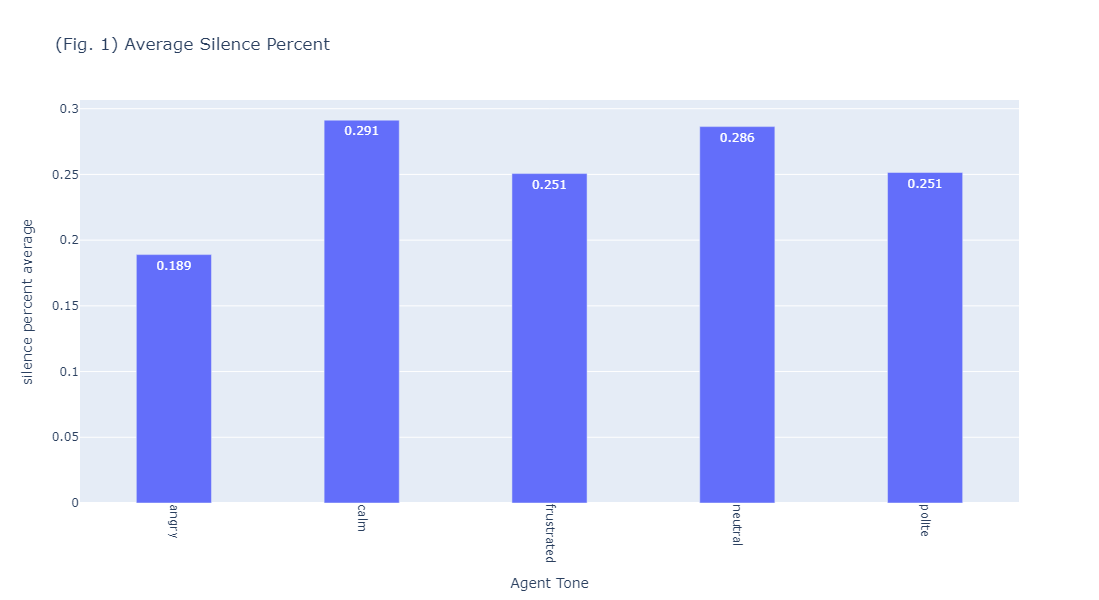

In [34]:
# Average Silent Percentage with Agent Tone
sil = final_result.groupby('agent_tone')[['Handle_minutes','silence_percent_average']].mean().reset_index()
fig = px.bar(data_frame = sil, x = 'agent_tone', y = "silence_percent_average", title='(Fig. 1) Average Silence Percent', labels={'agent_tone': 'Agent Tone', 'silence_percent_average': 'silence percent average'}, text_auto = '.3', barmode = 'group')

fig.update_layout(xaxis_tickangle = 90, width=1000, height=600) 
fig.update_traces(width=0.4) # Bar size fig.show()

### CORRELATION MATRIX 
#### Correlation between Average Sentiment, Average Silent Percentage, Handling Time

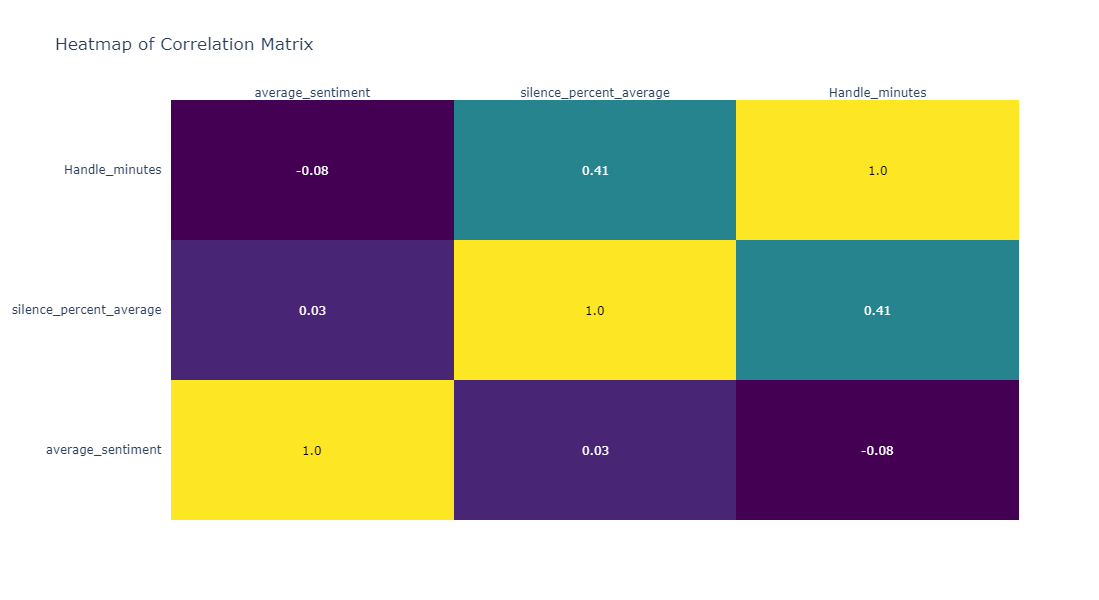

In [35]:
cor = round(final_result[['average_sentiment', 'silence_percent_average','Handle_minutes']].corr(),2)
import plotly.figure_factory as ff

# Create a heatmap
fig = ff.create_annotated_heatmap(
    z=cor.values,
    x=cor.columns.tolist(),
    y=cor.index.tolist(),
    colorscale='Viridis',  # You can choose other colorscales as well
)

# Update layout for better visualization
fig.update_layout(
    title='Heatmap of Correlation Matrix',
    width=1000, height=600
)

# Show the figure
fig.show()

#### SENTIMENT IMPACT ANALYSIS

In [36]:
sentiment_impact = final_result.groupby(['customer_tone','agent_tone'])[['Handle_minutes','silence_percent_average']].mean().reset_index()
# Sorting by handle time for insights
sorted_sentiment_impact = sentiment_impact.sort_values(by='Handle_minutes',ascending = False)
sorted_sentiment_impact = sorted_sentiment_impact.reset_index(drop = True)
sorted_sentiment_impact.head(3)

customer_tone agent_tone  Handle_minutes  silence_percent_average
0       neutral    neutral       12.697107                 0.291287
1          calm    neutral       12.516789                 0.285244
2         angry    neutral       12.485026                 0.283444

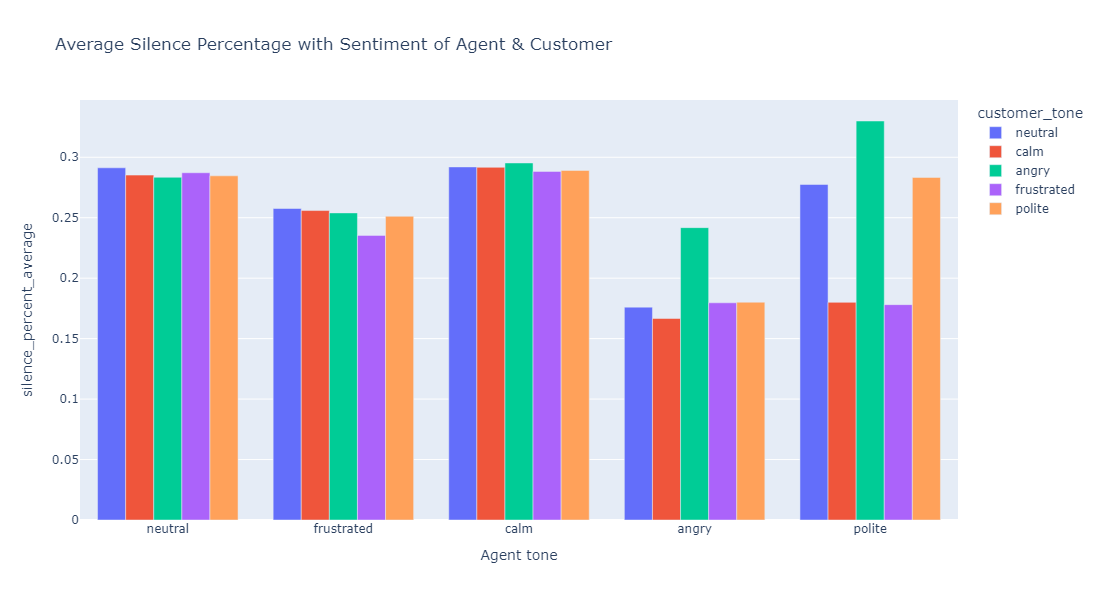

In [37]:
# Average Silence Percentage with Sentiment of Agent & Customer
import plotly.express as px
import pandas as pd

# Create the bar graph with facet grids
fig = px.bar(sorted_sentiment_impact, color='customer_tone', y='silence_percent_average', x='agent_tone',barmode='group',
             title='Average Silence Percentage with Sentiment of Agent & Customer',
             labels={'agent_tone': 'Agent tone', 'Handle_minutes': 'Average Handling Time'},)

# Show the plot
# Update layout for better visualization
fig.update_layout(
    width=1000, height=600
)
fig.show()

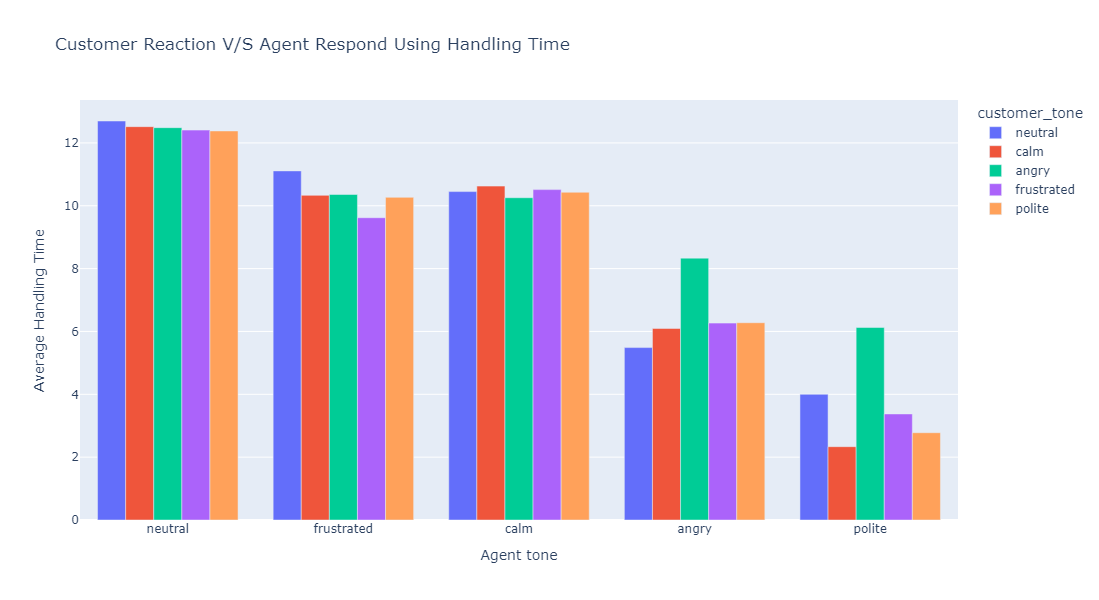

In [38]:
# Customer Reaction V/S Agent Respond Using Handling Time
import plotly.express as px
import pandas as pd

# Create the bar graph with facet grids
fig = px.bar(sorted_sentiment_impact, color='customer_tone', y='Handle_minutes', x='agent_tone',barmode='group',
             title='Customer Reaction V/S Agent Respond Using Handling Time',
             labels={'agent_tone': 'Agent tone', 'Handle_minutes': 'Average Handling Time'},)

# Show the plot
# Update layout for better visualization
fig.update_layout(
    width=1000, height=600
)
fig.show()

## AST  with Sentiment

In [41]:
print("AVERAGE SPEED TIME")
print("*"*100)
print(final_result.groupby('customer_tone')[['Speed_minutes','silence_percent_average']].mean())
print("*"*100)
print(final_result.groupby('agent_tone')[['Speed_minutes','silence_percent_average']].mean())

AVERAGE SPEED TIME
****************************************************************************************************
               Speed_minutes  silence_percent_average
customer_tone                                        
angry               7.281529                 0.285816
calm                7.287549                 0.285391
frustrated          7.274320                 0.283956
neutral             7.294179                 0.289119
polite              7.274586                 0.283824
****************************************************************************************************
            Speed_minutes  silence_percent_average
agent_tone                                        
angry            7.087432                 0.188989
calm             7.395595                 0.291282
frustrated       7.061955                 0.250628
neutral          7.237251                 0.286358
polite           7.703704                 0.251481


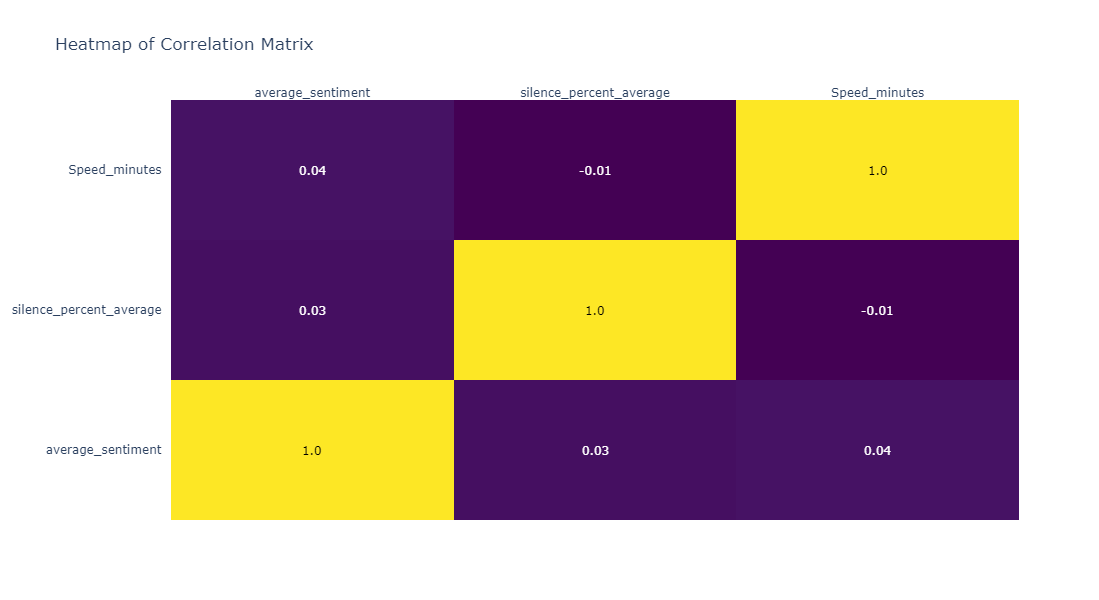

In [42]:
cor = round(final_result[['average_sentiment', 'silence_percent_average','Speed_minutes']].corr(),2)
import plotly.figure_factory as ff

# Create a heatmap
fig = ff.create_annotated_heatmap(
    z=cor.values,
    x=cor.columns.tolist(),
    y=cor.index.tolist(),
    colorscale='Viridis',  # You can choose other colorscales as well
)

# Update layout for better visualization
fig.update_layout(
    title='Heatmap of Correlation Matrix',
    width=1000, height=600
)

# Show the figure
fig.show()

### OBSERVATION
- No Conclusive Evident

# -----------------------------------------------------------------------------
## 4.3 Primary Call Reason vs Handling times
- **Finding Call Reasons which are affecting Handling times**
- **For that we are going to do ABC Analysis using Pareto chart**
# -----------------------------------------------------------------------------

In [43]:
# Dividing the class based on AHT

d = final_result['primary_call_reason'].value_counts()
d = d.reset_index()
d.columns = ['primary_call_reason', 'count']

# Finding the Cumulative
d['count_cumulative'] = d['count'].cumsum()

# Allocate Reasons it into different classes which we found in ABC Analysis in below
classA = ['Checkout', 'Mileage Plus', 'ETC', 'Post Flight', 'Communications',
       'IRROPS', 'Products and Services', 'Voluntary Cancel',
       'Voluntary Change', 'Upgrade', 'Check In']
classB = ['Unaccompanied Minor','Schedule Change', 'Seating', 'Booking', 'Traveler Updates']
classC = ['Digital Support','Baggage','Disability','Other Topics']

d['Class'] = ''
for index, x in enumerate(d['primary_call_reason']):
    if x in classA:
        d.at[index, 'Class'] = 'Class A'
    elif x in classB:
        d.at[index, 'Class'] = 'Class B'
    else:
        d.at[index, 'Class'] = 'Class C'
        
# Sorting based on count of each reasons
d = d.sort_values(by='count', ascending = False)
d

primary_call_reason  count  count_cumulative    Class
0                  IRROPS  13264             13264  Class A
1        Voluntary Change  10827             24091  Class A
2                 Seating   6355             30446  Class B
3            Mileage Plus   5837             36283  Class A
4             Post Flight   4309             40592  Class A
5          Communications   3836             44428  Class A
6   Products and Services   3323             47751  Class A
7                 Baggage   2808             50559  Class C
8                 Upgrade   2734             53293  Class A
9                 Booking   2624             55917  Class B
10               Check In   1899             57816  Class A
11               Checkout   1882             59698  Class A
12       Voluntary Cancel   1603             61301  Class A
13        Digital Support   1220             62521  Class C
14                    ETC    950             63471  Class A
15       Traveler Updates    932             64403  Class B
16           Other Topics    816             65219  Class C
17        Schedule Change    730             65949  Class B
18             Disability    402             66351  Class C
19    Unaccompanied Minor    104             66455  Class B

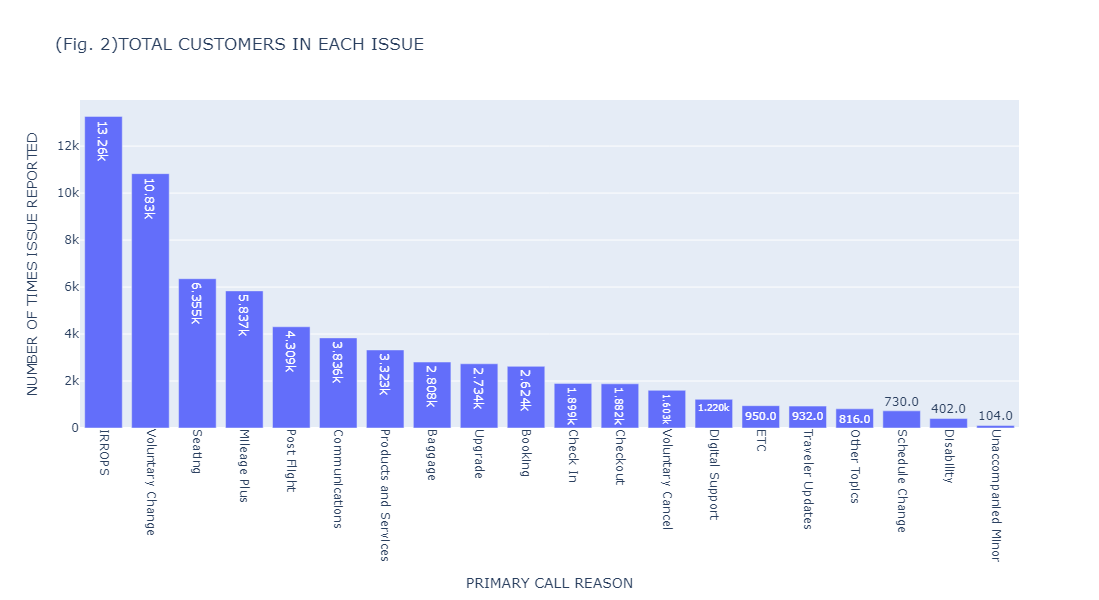

In [44]:
# TOTAL CUSTOMERS IN EACH ISSUE
# Create a bar plot
fig = px.bar(data_frame = d, 
             x = 'primary_call_reason',
             y = "count",
             title='(Fig. 2)TOTAL CUSTOMERS IN EACH ISSUE',
             labels={'primary_call_reason': 'PRIMARY CALL REASON', 'count': 'NUMBER OF TIMES ISSUE REPORTED'},
             text_auto = '.4s',
            barmode = 'stack')

fig.update_layout(xaxis_tickangle = 90, width=1000, height=600)
fig.show()

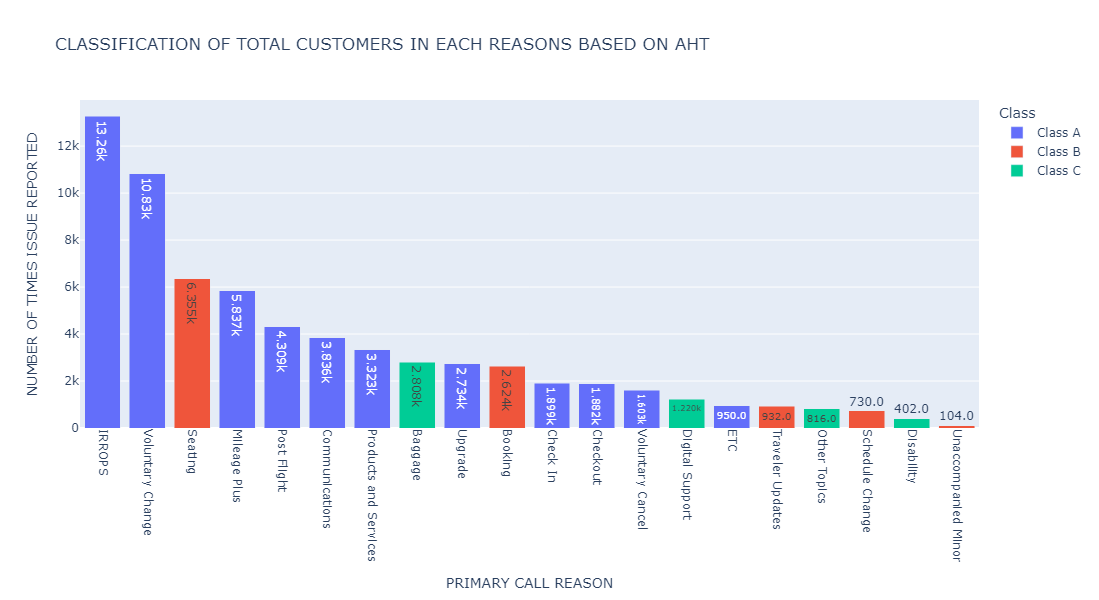

In [45]:
# TOTAL CUSTOMERS IN EACH ISSUE BASED ON CLASS A, B & C
# Create a bar plot
fig1 = px.bar(data_frame = d, 
             x = d.index,
             y = "count",
             hover_data = ['Class'],
             color = "Class",
             title='CLASSIFICATION OF TOTAL CUSTOMERS IN EACH REASONS BASED ON AHT',
             labels={'index': 'PRIMARY CALL REASON', 'count': 'NUMBER OF TIMES ISSUE REPORTED'},
             text_auto = '.4s',
            barmode = 'stack')

fig1.update_layout(xaxis = dict(tickangle = 90, tickvals=d.index, ticktext = d["primary_call_reason"]), width=1000, height=600)
fig1.show()

In [46]:
# Dividing the class based on AST

d = final_result['primary_call_reason'].value_counts()
d = d.reset_index()
d.columns = ['primary_call_reason', 'count']

# Finding the Cumulative
d['count_cumulative'] = d['count'].cumsum()

# Allocate Reasons it into different classes which we found in ABC Analysis in below
classA = ['Checkout', 'Travel Updates', 'Unaccompanied Minor', 'Seating', 'Post Flight', 'ETC', 'Baggage', 
          'Voluntary Change', 'Digital Support', 'Disability']
classB = ['Mileage Plus', 'IRROPS', 'Check In', 'Product Services', 'Upgrades']
classC = ['Schedule Change', 'Booking', 'Communication' , 'Other Topics']

d['Class'] = ''
for index, x in enumerate(d['primary_call_reason']):
    if x in classA:
        d.at[index, 'Class'] = 'Class A'
    elif x in classB:
        d.at[index, 'Class'] = 'Class B'
    else:
        d.at[index, 'Class'] = 'Class C'
        
# Sorting based on count of each reasons
d = d.sort_values(by='count', ascending = False)
d

primary_call_reason  count  count_cumulative    Class
0                  IRROPS  13264             13264  Class B
1        Voluntary Change  10827             24091  Class A
2                 Seating   6355             30446  Class A
3            Mileage Plus   5837             36283  Class B
4             Post Flight   4309             40592  Class A
5          Communications   3836             44428  Class C
6   Products and Services   3323             47751  Class C
7                 Baggage   2808             50559  Class A
8                 Upgrade   2734             53293  Class C
9                 Booking   2624             55917  Class C
10               Check In   1899             57816  Class B
11               Checkout   1882             59698  Class A
12       Voluntary Cancel   1603             61301  Class C
13        Digital Support   1220             62521  Class A
14                    ETC    950             63471  Class A
15       Traveler Updates    932             64403  Class C
16           Other Topics    816             65219  Class C
17        Schedule Change    730             65949  Class C
18             Disability    402             66351  Class A
19    Unaccompanied Minor    104             66455  Class A

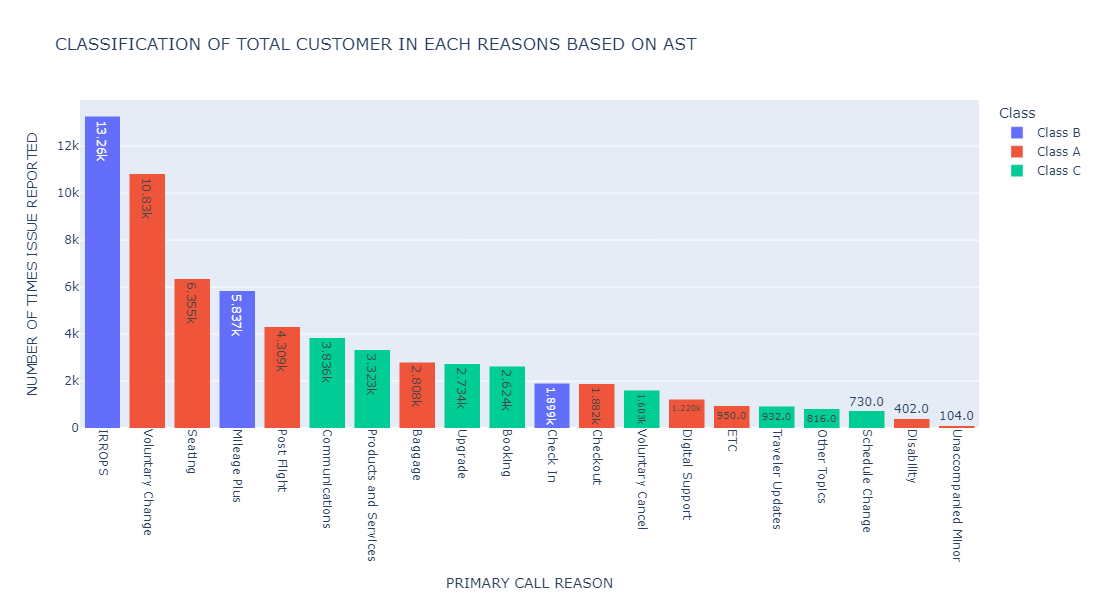

In [47]:
# TOTAL CUSTOMERS IN EACH ISSUE BASED ON CLASS A, B & C
# Create a bar plot
fig1 = px.bar(data_frame = d, 
             x = d.index,
             y = "count",
             hover_data = ['Class'],
             color = "Class",
             title='CLASSIFICATION OF TOTAL CUSTOMER IN EACH REASONS BASED ON AST',
             labels={'index': 'PRIMARY CALL REASON', 'count': 'NUMBER OF TIMES ISSUE REPORTED'},
             text_auto = '.4s',
            barmode = 'stack')

fig1.update_layout(xaxis = dict(tickangle = 90, tickvals=d.index, ticktext = d["primary_call_reason"]), width=1000, height=600)
fig1.show()

In [48]:
a = final_result.groupby('primary_call_reason', as_index=False)['Handle_minutes'].mean()
print(a.head())

  primary_call_reason  Handle_minutes
0             Baggage        5.599359
1             Booking        7.150534
2            Check In        9.588731
3            Checkout       16.994155
4      Communications       13.788321


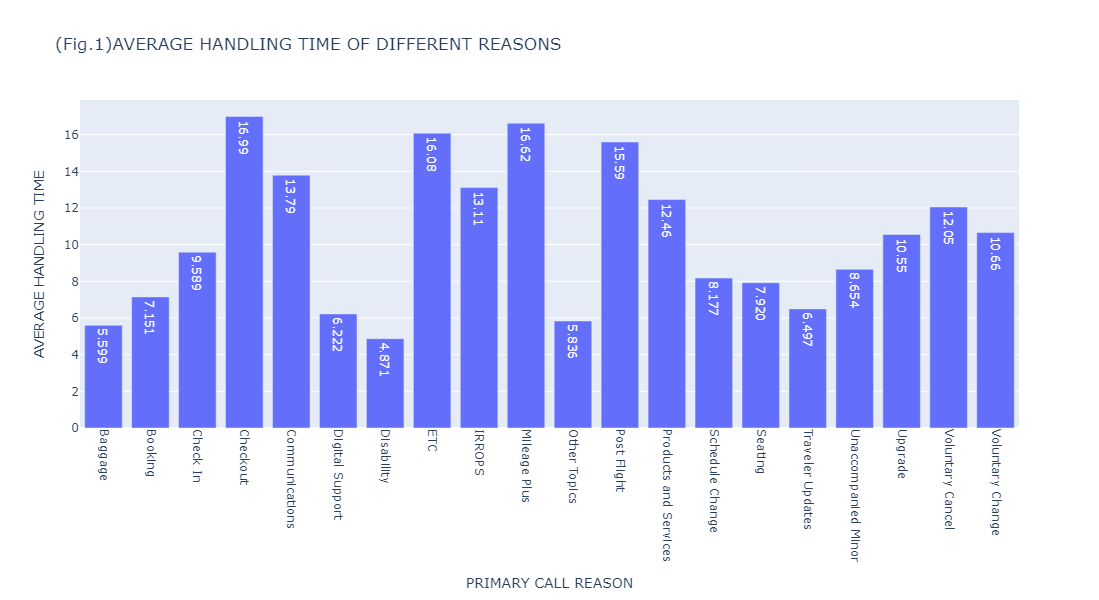

In [49]:
# Average HAndling time of different reasons
# Create a bar plot
fig = px.bar(data_frame = a, 
             x = "primary_call_reason",
             y = "Handle_minutes",
             title='(Fig.1)AVERAGE HANDLING TIME OF DIFFERENT REASONS',
             labels={'primary_call_reason': 'PRIMARY CALL REASON', 'Handle_minutes': 'AVERAGE HANDLING TIME'},
             text_auto = '.4s',
            barmode = 'group')

fig.update_layout(xaxis_tickangle=90, width=1000, height=600)
#fig.update_traces(marker_color='skyblue')
fig.show()

In [50]:
print("Percentage difference between AHT for the most frquent and less frequent call reasons is", round(((a.loc[8][1] - a.loc[16][1])/a.loc[16][1])*100, 2), "%." )

Percentage difference between AHT for the most frquent and less frequent call reasons is 51.5 %.


### OBSERVATION
- **IRROPS** and **Unaccompanied minor** are two most frequent and least frequent calling reasons respectively.
- **Checkout**, **Mileage PLus**, **ETC** are the major reasons for high AHT.
- **% difference between AHT for the most frquent and less frequent call reasons =**
$\frac{(AHT of IRROPS - AHT of Unaccompanied minor))}{(AHT of Unaccompanied minor)}*100$
- % difference between AHT for the most frquent and less frequent call reasons is 51.5%

### ABC Analysis Of Reasons

In [51]:
a = final_result.groupby('primary_call_reason', as_index=False)['Handle_minutes'].mean()
a['% of avg handling time'] = [(x/a['Handle_minutes'].sum())*100 for x in a['Handle_minutes']]
sorted_a = a.sort_values(by='% of avg handling time', ascending=False).reset_index(drop = True)
sorted_a["cumulative % handling time"] = sorted_a["% of avg handling time"].cumsum()
sorted_a.head()

primary_call_reason  Handle_minutes  % of avg handling time  \
0            Checkout       16.994155                8.154020   
1        Mileage Plus       16.618297                7.973678   
2                 ETC       16.077895                7.714386   
3         Post Flight       15.594570                7.482480   
4      Communications       13.788321                6.615818   

   cumulative % handling time  
0                    8.154020  
1                   16.127697  
2                   23.842083  
3                   31.324563  
4                   37.940381

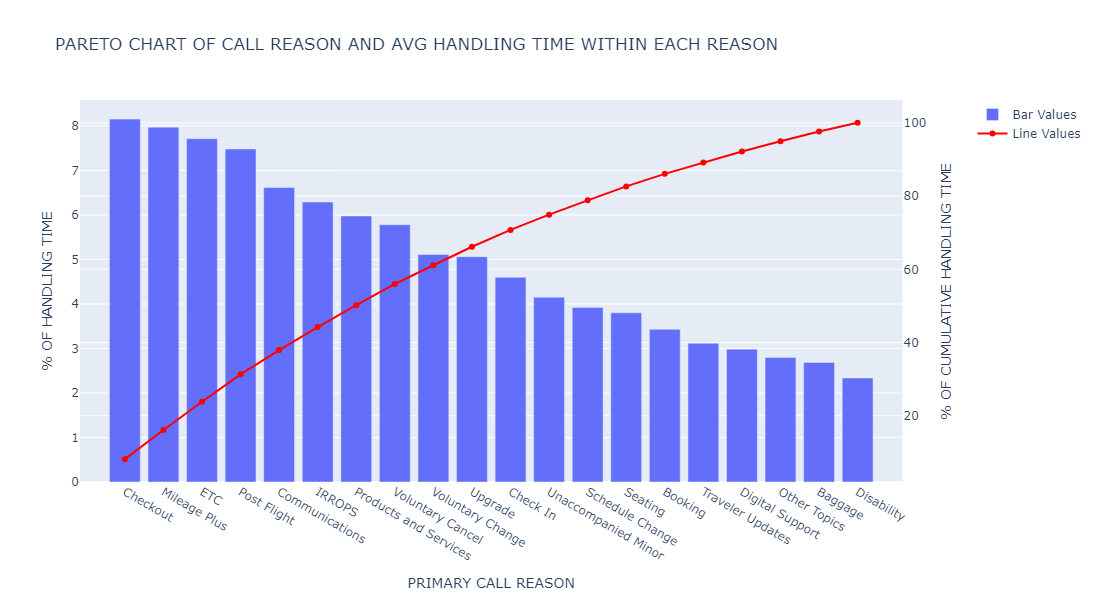

In [52]:
# PARETO CHART
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar chart
fig.add_trace(
    go.Bar(x=sorted_a["primary_call_reason"], y=sorted_a["% of avg handling time"], 
           name='Bar Values'),
    secondary_y=False  # Use primary y-axis
)

# Add line chart
fig.add_trace(
    go.Scatter(x=sorted_a["primary_call_reason"], y=sorted_a["cumulative % handling time"], 
               name='Line Values', mode='lines+markers', marker_color='red'),
    secondary_y=True  # Use secondary y-axis
)

# Update layout
fig.update_layout(
    title='PARETO CHART OF CALL REASON AND AVG HANDLING TIME WITHIN EACH REASON',
    xaxis_title='PRIMARY CALL REASON',
    yaxis_title='% OF HANDLING TIME',
    yaxis2_title='% OF CUMULATIVE HANDLING TIME',
    legend_title='',
    barmode='group',
    width=1000, 
    height=600
)

# Show the figure
fig.show()


In [53]:
# Important reasons which determine handling time
final_df = sorted_a[sorted_a["cumulative % handling time"] < 71]
final_df

primary_call_reason  Handle_minutes  % of avg handling time  \
0                Checkout       16.994155                8.154020   
1            Mileage Plus       16.618297                7.973678   
2                     ETC       16.077895                7.714386   
3             Post Flight       15.594570                7.482480   
4          Communications       13.788321                6.615818   
5                  IRROPS       13.110600                6.290639   
6   Products and Services       12.458622                5.977811   
7        Voluntary Cancel       12.049906                5.781704   
8        Voluntary Change       10.655768                5.112778   
9                 Upgrade       10.551573                5.062784   
10               Check In        9.588731                4.600799   

    cumulative % handling time  
0                     8.154020  
1                    16.127697  
2                    23.842083  
3                    31.324563  
4                    37.940381  
5                    44.231020  
6                    50.208831  
7                    55.990535  
8                    61.103312  
9                    66.166096  
10                   70.766895

In [54]:
# Reasons which are classified into class A
final_df["primary_call_reason"].unique()

array(['Checkout', 'Mileage Plus', 'ETC', 'Post Flight', 'Communications',
       'IRROPS', 'Products and Services', 'Voluntary Cancel',
       'Voluntary Change', 'Upgrade', 'Check In'], dtype=object)

## AST vs REASONS OF CALL

In [55]:
final_result.head(3)

call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118 2024-07-31 23:56:00   
1  1122072124   8186702651    519057 2024-08-01 00:03:00   
2  6834291559   2416856629    158319 2024-07-31 23:59:00   

  agent_assigned_datetime   call_end_datetime  \
0     2024-08-01 00:03:00 2024-08-01 00:34:00   
1     2024-08-01 00:06:00 2024-08-01 00:18:00   
2     2024-08-01 00:07:00 2024-08-01 00:26:00   

                                     call_transcript primary_call_reason  \
0  \n\nAgent: Thank you for calling United Airlin...    Voluntary Cancel   
1  \n\nAgent: Thank you for calling United Airlin...             Booking   
2  \n\nAgent: Thank you for calling United Airlin...              IRROPS   

  agent_tone customer_tone  average_sentiment  silence_percent_average  \
0    neutral         angry              -0.04                     0.39   
1       calm       neutral               0.02                     0.35   
2    neutral        polite              -0.13                     0.32   

    customer_name  elite_level_code           Speed          Handle  \
0  Matthew Foster               4.0 0 days 00:07:00 0 days 00:31:00   
1   Tammy Walters               0.0 0 days 00:03:00 0 days 00:12:00   
2   Jeffery Dixon               0.0 0 days 00:08:00 0 days 00:19:00   

   Speed_seconds  Handle_seconds  Speed_minutes  Handle_minutes  
0          420.0          1860.0            7.0            31.0  
1          180.0           720.0            3.0            12.0  
2          480.0          1140.0            8.0            19.0

  primary_call_reason  Handle_minutes  % of avg handling time
0             Baggage        5.599359                2.686646
1             Booking        7.150534                3.430920
2            Check In        9.588731                4.600799
3            Checkout       16.994155                8.154020
4      Communications       13.788321                6.615818


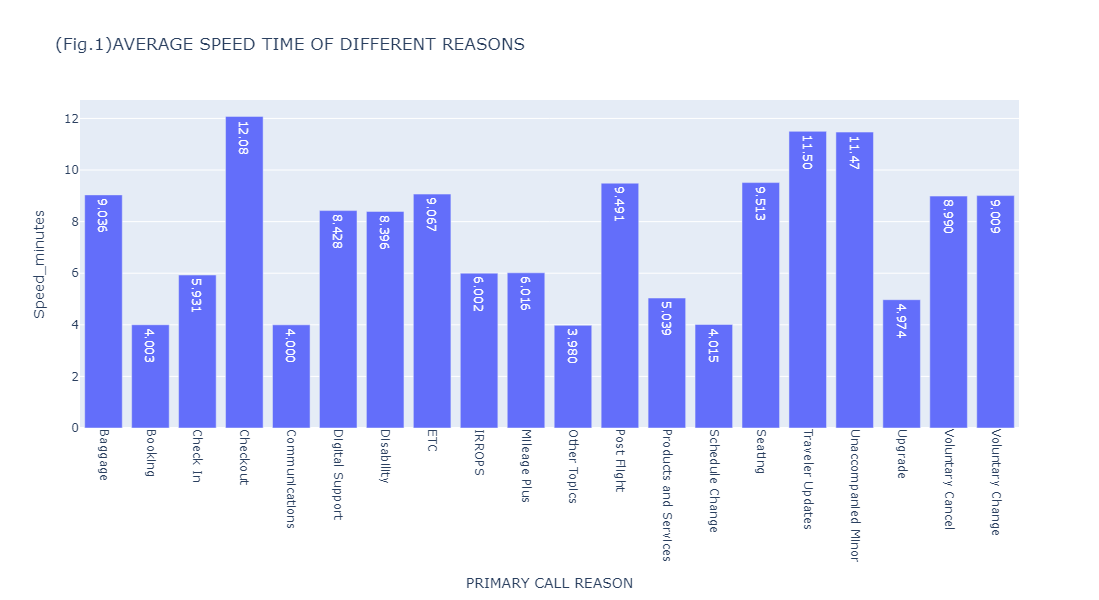

In [56]:
sp = final_result.groupby('primary_call_reason', as_index=False)['Speed_minutes'].mean()
print(a.head())
# Average HAndling time of different reasons
# Create a bar plot
fig = px.bar(data_frame = sp, 
             x = "primary_call_reason",
             y = "Speed_minutes",
             title='(Fig.1)AVERAGE SPEED TIME OF DIFFERENT REASONS',
             labels={'primary_call_reason': 'PRIMARY CALL REASON', 'Handle_minutes': 'AVERAGE HANDLING TIME'},
             text_auto = '.4s',
            barmode = 'group')

fig.update_layout(xaxis_tickangle=90, width=1000, height=600)
#fig.update_traces(marker_color='skyblue')
fig.show()

In [57]:
sp = final_result.groupby('primary_call_reason', as_index=False)['Speed_minutes'].mean()
sp['% of avg Speed time'] = [(x/sp['Speed_minutes'].sum())*100 for x in sp['Speed_minutes']]
sorted_sp = sp.sort_values(by='% of avg Speed time', ascending=False).reset_index(drop = True)
sorted_sp["cumulative % speed time"] = sorted_sp["% of avg Speed time"].cumsum()
sorted_sp.head()

primary_call_reason  Speed_minutes  % of avg Speed time  \
0             Checkout      12.079171             8.002649   
1     Traveler Updates      11.498927             7.618228   
2  Unaccompanied Minor      11.471154             7.599828   
3              Seating       9.513297             6.302715   
4          Post Flight       9.490601             6.287679   

   cumulative % speed time  
0                 8.002649  
1                15.620878  
2                23.220705  
3                29.523421  
4                35.811100

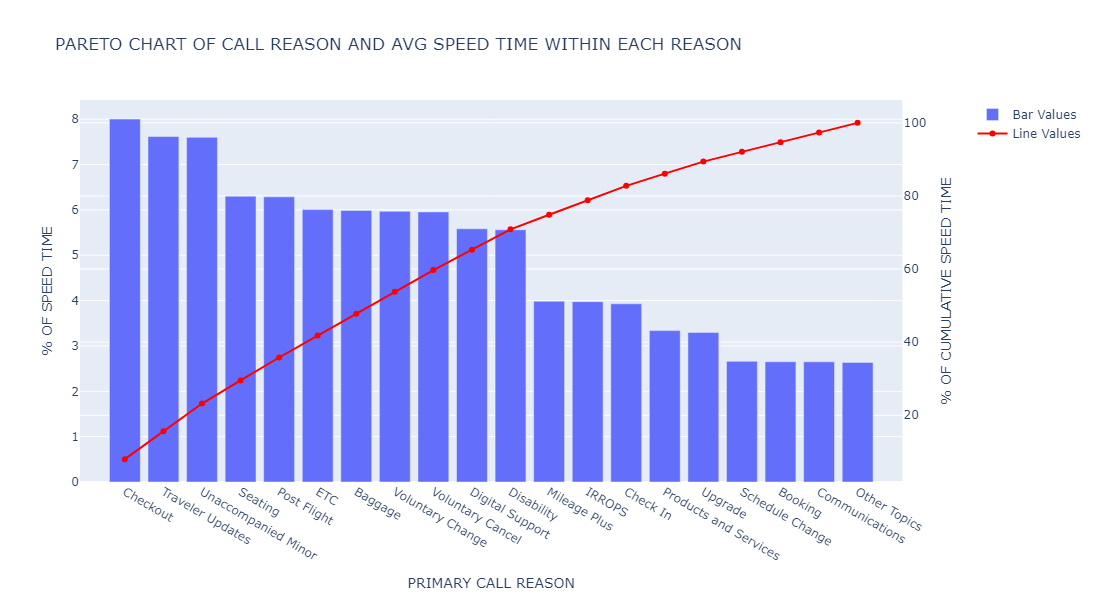

In [58]:
# PARETO CHART
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar chart
fig.add_trace(
    go.Bar(x=sorted_sp["primary_call_reason"], y=sorted_sp["% of avg Speed time"], 
           name='Bar Values'),
    secondary_y=False  # Use primary y-axis
)

# Add line chart
fig.add_trace(
    go.Scatter(x=sorted_sp["primary_call_reason"], y=sorted_sp["cumulative % speed time"], 
               name='Line Values', mode='lines+markers', marker_color='red'),
    secondary_y=True  # Use secondary y-axis
)

# Update layout
fig.update_layout(
    title='PARETO CHART OF CALL REASON AND AVG SPEED TIME WITHIN EACH REASON',
    xaxis_title='PRIMARY CALL REASON',
    yaxis_title='% OF SPEED TIME',
    yaxis2_title='% OF CUMULATIVE SPEED TIME',
    legend_title='',
    barmode='group', 
    width=1000, 
    height=600
)

# Show the figure
fig.show()